# Data Exploration: word reading score and brain anatomy

Using various vertex-wise GLM's to:  
- identify candidate areas of interest
- roughly estimate effect size / significance of relations / interactions

Download the data (Stanford Sherlock account with appropriate access required):  
- in the command line, navigate to the local directory where you are running this notebook
- execute the following command: ```scp -r {username}@login.sherlock.stanford.edu:/scratch/groups/jyeatman/samjohns-projects/reading-anatomy-exploration/data .```
- this will download both the original data as well as filtered versions ready for immediate analysis, which are saved in .pkl ("pickle") files
- WARNING: in case there is a preexisting subdirectory ./data, this command could overwrite it. Thus it is advised to run this notebook from within its own dedicated direcotry.

In [1]:
from nilearn import datasets
from nilearn import surface
from nilearn import plotting

import math
import numpy as np
from scipy import stats
import nibabel as nib
import pandas as pd

# from sklearn.linear_model import LinearRegression # removed in favor of statsmodels, below
import statsmodels.api as sm
import statsmodels.formula.api as smf

import os
import pickle

/home/groups/jyeatman/software/anaconda3/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


## 0. Data preparation: skip this section to directly load an already-processed dataframe

(This section is kept as a record of preprocessing steps.)

In [2]:
# preparing data

datapath = './data/'
# Load fsaverage
fsaverage = datasets.fetch_surf_fsaverage('fsaverage')

# Load cortical anatomy data
ct = surface.load_surf_data(datapath + 'lh.thickness.DyslexiaControlContrast.10.mgz')
cv = surface.load_surf_data(datapath + 'lh.curv.DyslexiaControlContrast.10.mgz')
sl = surface.load_surf_data(datapath + 'lh.sulc.DyslexiaControlContrast.10.mgz')

# Load csv (of WIAT scores)
read = pd.read_csv(datapath + 'wiat_reading.csv', header=None)
read_col = np.array(read[1])
read_float = np.array([np.nan if r == ' ' else float(r) for r in read_col])

# Load csv (of ages)
age = pd.read_csv(datapath + 'hbn_ages_blanks.csv', header=None)
age_col = np.array(read[1])
age_float = np.array([np.nan if r == ' ' else float(r) for r in read_col])


Dataset created in /home/users/samjohns/nilearn_data/fsaverage



Downloaded 23953408 of 28905506 bytes (82.9%,    0.4s remaining) ...done. (5 seconds, 0 min)
Extracting data from /home/users/samjohns/nilearn_data/fsaverage/5592d63c5c8039b4f902396c128dcd85/download..... done.


In [4]:
ct.shape

(163842, 1659)

In [5]:
# merge age and reading scores into one matrix X of inputs

age.columns = ['EID', 'Age']
read.columns = ['EID', 'Read']

pheno_unfiltered = pd.merge(read, age, on='EID')
pheno_nonblanks = pheno_unfiltered[(pheno_unfiltered.Read != ' ') & (pheno_unfiltered.Age != ' ')]
nonblank_inds = list(pheno_nonblanks.EID.index.values)

# cast to float for use in models
readf = np.array([float(x) for x in pheno_nonblanks['Read'].values])
agef = np.array([float(x) for x in pheno_nonblanks['Age'].values])

# remove corresponding anatomical data
ctf = ct[:, nonblank_inds]
cvf = cv[:, nonblank_inds]
slf = sl[:, nonblank_inds]

# check shapes are compatible
ctf.shape, cvf.shape, slf.shape, readf.shape, agef.shape

((163842, 1412), (163842, 1412), (163842, 1412), (1412,), (1412,))

In [6]:
# assemble into one dataframe per vertex
# test on one vertex (v=0)
pre_df = np.stack([ctf[0], cvf[0], slf[0], agef, readf], axis=1)
df = pd.DataFrame(data=pre_df, columns=['Thickness', 'Curvature', 'SulcalDepth', 'Age', 'ReadingWIATScore'])
df

,Thickness,Curvature,SulcalDepth,Age,ReadingWIATScore
0,2.886009,-0.110603,-6.476887,7.0,146.0
1,2.905436,-0.130158,-4.872353,12.0,123.0
2,3.085148,-0.130295,-5.295219,8.0,96.0
3,2.965068,-0.135768,-5.802252,11.0,98.0
4,2.714352,-0.095571,-5.329716,6.0,123.0
...,...,...,...,...,...
1407,2.740551,-0.123050,-4.284818,8.0,73.0
1408,3.203292,-0.173358,-6.496359,11.0,96.0
1409,3.010693,-0.127864,-5.774803,8.0,67.0
1410,2.725559,-0.111646,-5.209313,21.0,46.0


In [7]:
# pickle data to reuse later

objs = [ctf, cvf, slf, readf, agef, nonblank_inds]
names = ['ctf', 'cvf', 'slf', 'readf', 'agef', 'nonblank_inds']

for obj, name in zip(objs, names):    
    with open(f'data/{name}.pkl', 'wb') as f:
        pickle.dump(obj, f)

## 1. GLM analysis:

p-values and $R^2$ values for each vertex

In [8]:
# if desired, load data directly from .pkl files

with open('data/ctf.pkl', 'rb') as f:
    ctf = pickle.load(f)

with open('data/cvf.pkl', 'rb') as f:
    cvf = pickle.load(f)

with open('data/slf.pkl', 'rb') as f:
    slf = pickle.load(f)

with open('data/readf.pkl', 'rb') as f:
    readf = pickle.load(f)

with open('data/agef.pkl', 'rb') as f:
    agef = pickle.load(f)

with open('data/nonblank_inds.pkl', 'rb') as f:
    nonblank_inds = pickle.load(f)
        
# check shapes are compatible (and expected number, e.g. N=1,412 in original analysis)
ctf.shape, cvf.shape, slf.shape

((163842, 1412), (163842, 1412), (163842, 1412))

In [9]:
readf.shape, agef.shape

((1412,), (1412,))

In [10]:
# now do vertex-wise regressions: test on vertex 0
# this displays the summary statistics that will be available at each vertex's regression
V = ctf.shape[0]
for v in range(1):
    pre_df = np.stack([ctf[v], cvf[v], slf[v], agef, readf], axis=1)
    df = pd.DataFrame(data=pre_df, columns=['Thickness', 'Curvature', 'SulcalDepth', 'Age', 'ReadingWIATScore'])
    result_linear = smf.ols('ReadingWIATScore ~ Age + Thickness + I(Age*Thickness)', data=df).fit()
    print(result_linear.summary())

                            OLS Regression Results                            
Dep. Variable:       ReadingWIATScore   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.749
Date:                Tue, 28 Dec 2021   Prob (F-statistic):             0.0415
Time:                        14:51:33   Log-Likelihood:                -5899.5
No. Observations:                1412   AIC:                         1.181e+04
Df Residuals:                    1408   BIC:                         1.183e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            102.4254     11

In [63]:
glm_coeffs = list(result_linear.pvalues.index)

In [68]:
pvals = []
r2s = []
column_names = ['Thickness', 'Curvature', 'SulcalDepth', 'Age', 'ReadingWIATScore']
glm_formula = 'ReadingWIATScore ~ Age + Thickness + I(Age*Thickness)'

record_all_results = False

# recording all summary statistics for each vertex takes longer and consumes more memory
if record_all_results:
    glm_results = []

for v in range(V):
    # create one dataframe per vertex
    pre_df = np.stack([ctf[v], cvf[v], slf[v], agef, readf], axis=1)
    df = pd.DataFrame(data=pre_df, columns=['Thickness', 'Curvature', 'SulcalDepth', 'Age', 'ReadingWIATScore'])
    
    # run a linear regression with the 'glm_formula' on this dataframe
    result_linear = smf.ols(glm_formula, data=df).fit()
    
    # record results of interest
    pvals.append(result_linear.pvalues.values[:])
    r2s.append(result_linear.rsquared)
    
    if record_all_results:
        glm_results.append(result_linear)

In [44]:
# check results are populated with correct number of vertices
len(pvals), len(r2s)

(163842, 163842)

In [49]:
r2s_arr = np.array(r2s)
pval_arr = np.array(pvals)
logpvals = np.log10(pval_arr)

<ipython-input-49-6fd9407afb90>:3: RuntimeWarning: divide by zero encountered in log10
  logpvals = np.log10(pval_arr)


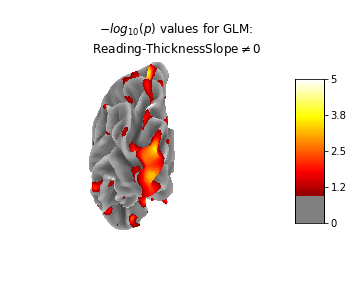

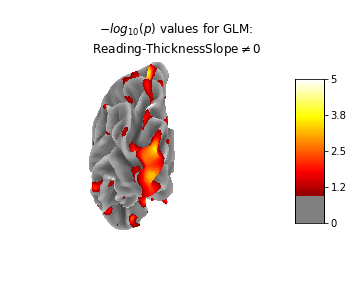

In [72]:
# Now plot the p-values for each vertex's regression
coeff = 'Thickness'
ind_thickness = glm_coeffs.index(coeff)
title = r'$-log_{10}(p)$' + ' values for GLM:\nReading-' + coeff + 'Slope'+r'$\neq 0$'

plotting.plot_surf_stat_map(fsaverage['white_left'], stat_map=-logpvals[:, ind_thickness],
    hemi='left', threshold=1., vmax=5., view='posterior', colorbar=True, legend='negative log p(vertex)',
    bg_map=fsaverage['curv_left'], title=title)